In [1]:
import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T
from datasets import load_dataset
import os
import glob
import matplotlib.pyplot as plt
import numpy as np
import librosa
#torch.manual_seed(42)

In [2]:
def plot_waveform(waveform, sr, title="Waveform"):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sr

    figure, axes = plt.subplots(num_channels, 1)
    axes.plot(time_axis, waveform[0], linewidth=1)
    axes.grid(True)
    figure.suptitle(title)
    plt.show(block=False)

def plot_spectrogram(specgram, title=None, ylabel="freq_bin"):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto")
    fig.colorbar(im, ax=axs)
    plt.show(block=False)


def plot_fbank(fbank, title=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Filter bank")
    axs.imshow(fbank, aspect="auto")
    axs.set_ylabel("frequency bin")
    axs.set_xlabel("mel bin")
    plt.show(block=False)

def plot_confusion_matrix(confusion_matrix, labels):
    fig, ax = plt.subplots(1, 1)
    ax.imshow(confusion_matrix, cmap="gray")
    ax.set_xticks(range(len(labels)))
    ax.set_yticks(range(len(labels)))
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Target")
    plt.show(block=False)

In [3]:
def count_label(dataset):
    label_count = {}
    for label in dataset['labels']:
        if label in label_count:
            label_count[label] += 1
        else:
            label_count[label] = 1
    return label_count

file_limit_train = 10000
file_limit_test = 10000

def load_dataset(path, is_test=False, simulated=False):
    # Create empty lists to store waveforms, sample rates and labels
    dataset = {'waveforms': [], 'sample_rates': [], 'labels': []}
    print("number of label:",len(os.listdir(path)))
    # Loop over the sub-folders in the root folder
    for folder in os.listdir(path):
        # Get the label from the folder name
        label = folder
        counter = 0
        # Loop over the audio files in each sub-folder
        for filename in glob.glob(os.path.join(path, folder, '*.wav')):
            if is_test and not is_test and filename.endswith("stereo.wav"):
                continue
            if simulated and not filename.endswith("stereo.wav"):
                continue
            counter += 1
            try:
                # Load an audio file as a tensor and its sample rate
                waveform, sample_rate = torchaudio.load(filename)
                if waveform.shape[1] < 86400:
                    continue
                if waveform.shape[1] > 86400:
                    waveform = waveform[:, :86400]
                # Append them to the lists
                dataset['waveforms'].append(waveform)
                dataset['sample_rates'].append(sample_rate)
                dataset['labels'].append(label)
                # Stop if we have enough audio files
                if counter >= file_limit_train and not is_test:
                    break
                if is_test and counter >= file_limit_test:
                    break
            except Exception as e:
                pass
    return dataset

In [4]:
""" train = load_dataset('..\\..\\..\\sound-propagation-simulation\\dataset\\train\\2023-04-19 09-34-19-train')
print("train dataset loaded, size:",len(train['waveforms']))
print(count_label(train)) 
test = load_dataset('..\\..\\..\\sound-propagation-simulation\\dataset\\test\\2023-04-19 10-24-13-test')
print("test dataset loaded, size:",len(test['waveforms']))
print(count_label(test)) """

train = load_dataset('..\\..\\..\\sound-propagation-simulation\\dataset_real_data\\v3\\train')

test = load_dataset('..\\..\\..\\sound-propagation-simulation\\dataset_real_data\\v3\\test', True)

"""print("test dataset loaded, size:",len(test['waveforms']))
print(count_label(test)) """
""" train['waveforms'].extend(test['waveforms'])
train['sample_rates'].extend(test['sample_rates'])
train['labels'].extend(test['labels']) """

split=.1
""" 
# split train and test with 80/20
train_size = int((1-split)*len(train_load['waveforms']))
test_size = len(train_load['waveforms']) - train_size

train = {'waveforms': [], 'sample_rates': [], 'labels': []}
test = {'waveforms': [], 'sample_rates': [], 'labels': []}

train['waveforms'] = train_load['waveforms'][:train_size]
train['sample_rates'] = train_load['sample_rates'][:train_size]
train['labels'] = train_load['labels'][:train_size]

test['waveforms'] = train_load['waveforms'][train_size:]
test['sample_rates'] = train_load['sample_rates'][train_size:]
test['labels'] = train_load['labels'][train_size:]

print("train dataset loaded, size:",len(train['waveforms']))
print(count_label(train))
print("test dataset loaded, size:",len(test['waveforms']))
print(count_label(test))
 """

""" train_simulated = load_dataset('..\\..\\..\\sound-propagation-simulation\\dataset_real_data\\v3_simulated', simulated=True)
print("train dataset loaded, size:",len(train_simulated['waveforms']))
print(count_label(train_simulated))

print("train dataset shape:",train_simulated['waveforms'][0].shape)

# append simulated data to train
train['waveforms'].extend(train_simulated['waveforms'])
train['sample_rates'].extend(train_simulated['sample_rates'])
train['labels'].extend(train_simulated['labels'])

print("train dataset loaded, size:",len(train['waveforms']))
print(count_label(train))
 """


number of label: 4
number of label: 4


' train_simulated = load_dataset(\'..\\..\\..\\sound-propagation-simulation\\dataset_real_data\\v3_simulated\', simulated=True)\nprint("train dataset loaded, size:",len(train_simulated[\'waveforms\']))\nprint(count_label(train_simulated))\n\nprint("train dataset shape:",train_simulated[\'waveforms\'][0].shape)\n\n# append simulated data to train\ntrain[\'waveforms\'].extend(train_simulated[\'waveforms\'])\ntrain[\'sample_rates\'].extend(train_simulated[\'sample_rates\'])\ntrain[\'labels\'].extend(train_simulated[\'labels\'])\n\nprint("train dataset loaded, size:",len(train[\'waveforms\']))\nprint(count_label(train))\n '

In [5]:
def crop_audio(waveforms):
    # append second channel after the end of first channel
    waveforms_cropped = [torch.cat((waveform, waveform), 1) for waveform in waveforms]
    # remove second channel
    waveforms_cropped = [waveform[0] for waveform in waveforms_cropped]
    return waveforms_cropped

train_waveforms = train['waveforms']
train_labels = train['labels']
test_waveforms = test['waveforms']
test_labels = test['labels']
""" 
train_waveforms_cropped = crop_audio(train_waveforms)
test_waveforms_cropped = crop_audio(test_waveforms) """


' \ntrain_waveforms_cropped = crop_audio(train_waveforms)\ntest_waveforms_cropped = crop_audio(test_waveforms) '

In [6]:
# create tensors from the lists
train_waveforms_tensor = torch.stack(train_waveforms)
test_waveforms_tensor = torch.stack(test_waveforms)
print(train_waveforms_tensor.shape)
# convert the labels to integers
label_to_int = {label: i for i, label in enumerate(set(train_labels))}
train_int_labels = [label_to_int[label] for label in train_labels]
train_int_labels = torch.tensor(train_int_labels)
print(train_int_labels.shape)
test_int_labels = [label_to_int[label] for label in test_labels]
test_int_labels = torch.tensor(test_int_labels)
print(test_int_labels.shape)
# print number of classes
int_to_label = {i: label for label, i in label_to_int.items()}
# print labels with their corresponding integer
print(int_to_label)

weights = [1-1.0 / count for label, count in count_label(train).items()]
print(weights)

torch.Size([1417, 2, 86400])
torch.Size([1417])
torch.Size([611])
{0: 'right_to_left', 1: 'multiple_cars', 2: 'no_car', 3: 'left_to_right'}
[0.9971910112359551, 0.9938650306748467, 0.9975369458128078, 0.9979674796747967]


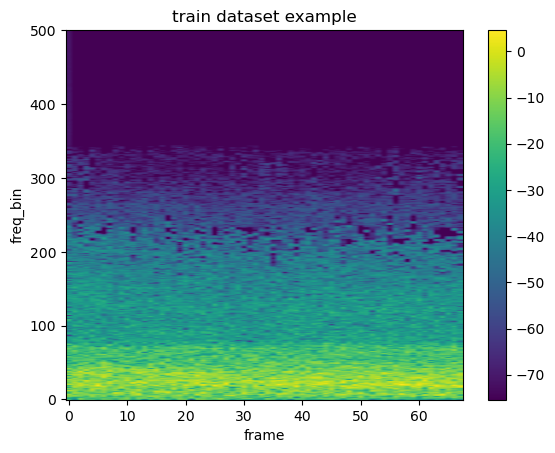

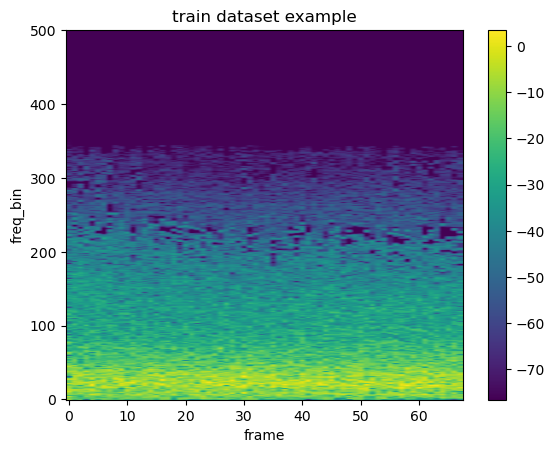

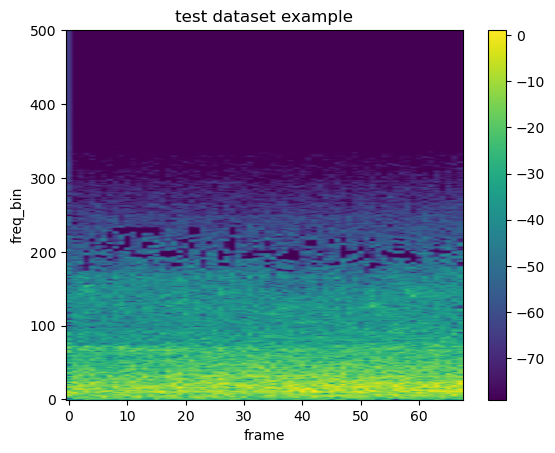

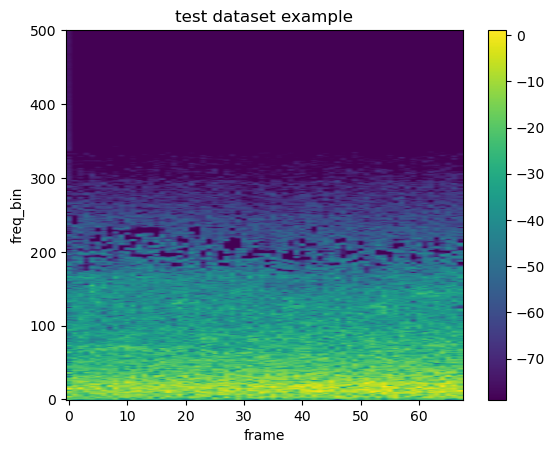

tensor(3)
torch.Size([2834, 2, 501, 68])
torch.Size([611, 2, 501, 68])


In [7]:
# convert the waveforms to log based spectrograms
train_spectrograms = [F.spectrogram(waveform, pad=0, window=torch.hann_window(1000), n_fft=1000, hop_length=1280, win_length=1000, power=2.0, normalized=True) for waveform in train_waveforms_tensor]
test_spectrograms = [F.spectrogram(waveform, pad=0, window=torch.hann_window(1000), n_fft=1000, hop_length=1280, win_length=1000, power=2.0, normalized=True) for waveform in test_waveforms_tensor]
train_spectrograms = torch.stack(train_spectrograms)
test_spectrograms = torch.stack(test_spectrograms)

# data augmentation by adding noise
train_spectrograms_aug = [F.spectrogram(waveform + torch.randn_like(waveform) * 0.001, pad=0, window=torch.hann_window(1000), n_fft=1000, hop_length=1280, win_length=1000, power=2.0, normalized=True) for waveform in train_waveforms_tensor]
train_spectrograms_aug = torch.stack(train_spectrograms_aug)
train_spectrograms = torch.cat((train_spectrograms, train_spectrograms_aug), 0)
train_int_labels = torch.cat((train_int_labels, train_int_labels), 0)



idx=0
plot_spectrogram(train_spectrograms[idx][0], title="train dataset example")
plot_spectrogram(train_spectrograms[idx][-1], title="train dataset example")
plot_spectrogram(test_spectrograms[idx][0], title="test dataset example")
plot_spectrogram(test_spectrograms[idx][-1], title="test dataset example")
print(train_int_labels[idx])
# add a channel dimension
print(train_spectrograms.shape)
print(test_spectrograms.shape)

In [8]:
# dataloader
from torch.utils.data import TensorDataset, DataLoader
train_dataset = TensorDataset(train_spectrograms, train_int_labels)
test_dataset = TensorDataset(test_spectrograms, test_int_labels)
# split the dataset into labels and features
X_train = train_dataset.tensors[0]
y_train = train_dataset.tensors[1] 
X_test = test_dataset.tensors[0]
y_test = test_dataset.tensors[1]
print(X_train.shape)
print(X_test.shape)

torch.Size([2834, 2, 501, 68])
torch.Size([611, 2, 501, 68])


In [9]:
import torch.nn as nn
from torchsummary import summary

import torch
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=2,
                out_channels=8,
                kernel_size=5,
                stride=1,
                padding=2,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=5),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(8, 16, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(16, 32, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.out = nn.Linear(1024, len(set(train_labels)))
        # dropout layer (p=0.5)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size(0), -1)
        output = self.out(x)
        return output, x    # return x for visualization


model = CNN()
summary(model, X_train.shape[1:])

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 8, 100, 13]          --
|    └─Conv2d: 2-1                       [-1, 8, 501, 68]          408
|    └─ReLU: 2-2                         [-1, 8, 501, 68]          --
|    └─MaxPool2d: 2-3                    [-1, 8, 100, 13]          --
├─Sequential: 1-2                        [-1, 16, 33, 4]           --
|    └─Conv2d: 2-4                       [-1, 16, 100, 13]         3,216
|    └─ReLU: 2-5                         [-1, 16, 100, 13]         --
|    └─MaxPool2d: 2-6                    [-1, 16, 33, 4]           --
├─Sequential: 1-3                        [-1, 32, 16, 2]           --
|    └─Conv2d: 2-7                       [-1, 32, 33, 4]           12,832
|    └─ReLU: 2-8                         [-1, 32, 33, 4]           --
|    └─MaxPool2d: 2-9                    [-1, 32, 16, 2]           --
├─Linear: 1-4                            [-1, 4]                   4,100
Tota

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 8, 100, 13]          --
|    └─Conv2d: 2-1                       [-1, 8, 501, 68]          408
|    └─ReLU: 2-2                         [-1, 8, 501, 68]          --
|    └─MaxPool2d: 2-3                    [-1, 8, 100, 13]          --
├─Sequential: 1-2                        [-1, 16, 33, 4]           --
|    └─Conv2d: 2-4                       [-1, 16, 100, 13]         3,216
|    └─ReLU: 2-5                         [-1, 16, 100, 13]         --
|    └─MaxPool2d: 2-6                    [-1, 16, 33, 4]           --
├─Sequential: 1-3                        [-1, 32, 16, 2]           --
|    └─Conv2d: 2-7                       [-1, 32, 33, 4]           12,832
|    └─ReLU: 2-8                         [-1, 32, 33, 4]           --
|    └─MaxPool2d: 2-9                    [-1, 32, 16, 2]           --
├─Linear: 1-4                            [-1, 4]                   4,100
Tota

In [14]:
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
def print_confusion_matrix(writer, test_loader, model, epoch):
    y_pred = []
    y_true = []
    for inputs, labels in test_loader:
        outputs = model(inputs)[0]
        _, predicted = torch.max(outputs.data, 1)
        for i in predicted:
            y_pred.append(i.cpu().numpy())
        for i in labels:
            y_true.append(i.cpu().numpy())
    cm = confusion_matrix(y_true, y_pred)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, xticklabels=list(int_to_label.values()), yticklabels=list(int_to_label.values()), fmt='g'); #annot=True to annotate cells
    # labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    writer.add_figure('Confusion Matrix', plt.gcf(), epoch)
    

In [17]:
import datetime
import tqdm
from torchmetrics.classification import MulticlassF1Score
time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
writer = SummaryWriter('runs_real_data/'+time+'-augmented-0.5-test')
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(torch.cuda.get_device_name(0))

# add adaptive learning rate
from torch.optim.lr_scheduler import ReduceLROnPlateau



# Create a CNN model
model = CNN()
# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss(weight=torch.tensor(weights).to(device))
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-3,)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=.5, patience=3, verbose=True)
# Train the model
batch_size = 64
num_epochs = 10000
model.to(device)
train_dataset = TensorDataset(X_train.to(device), y_train.to(device))
test_dataset = TensorDataset(X_test.to(device), y_test.to(device))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

for epoch in range(num_epochs):
    for i in range(0,len(train_loader)):
        with torch.set_grad_enabled(True):
            model.train()
            # Get the inputs and labels
            inputs, labels = next(iter(train_loader))
            # Forward pass
            outputs,x = model(inputs)
            loss = criterion(outputs, labels)
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    if (epoch+1) % 3 == 0:
        with torch.no_grad():
            model.eval()
            test_loss = 0
            correct = 0
            total = 0
            iterator = iter(test_loader)
            for i in range(0,len(test_loader)):
                inputs, labels = next(iterator)
                outputs, x = model(inputs)
                test_loss += criterion(outputs, labels).item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                predicted = torch.cat((predicted, predicted), 0)
            writer.add_scalar('loss/train', loss.item(), epoch)
            writer.add_scalar('accuracy/test', 100 * correct / total, epoch)
            writer.add_scalar('learning_rate', optimizer.param_groups[0]['lr'], epoch)
            writer.add_scalar('loss/test', test_loss, epoch)
            print_confusion_matrix(writer, test_loader, model, epoch)
            print('Epoch: {}, Loss: {:.4f}, Test Accuracy: {:.2f}%, Learning Rate: {}, Test Loss: {:.2f}'.format(epoch+1, loss.item(), 100 * correct / total, optimizer.param_groups[0]['lr'], test_loss))
    if (epoch+1)%20000 == 0:
        print('Model saved to model_{}.ckpt'.format(epoch+1))
    scheduler.step(loss)
    if optimizer.param_groups[0]['lr'] < 1e-7:
        torch.save(model.state_dict(), '../models/model_base_2.ckpt')
        break

NVIDIA GeForce RTX 4070 Ti
Epoch: 3, Loss: 0.9677, Test Accuracy: 53.68%, Learning Rate: 0.001, Test Loss: 10.16
Epoch: 6, Loss: 0.9665, Test Accuracy: 54.34%, Learning Rate: 0.001, Test Loss: 9.99
Epoch: 9, Loss: 1.0178, Test Accuracy: 57.12%, Learning Rate: 0.001, Test Loss: 10.13
Epoch 00011: reducing learning rate of group 0 to 5.0000e-04.
Epoch: 12, Loss: 0.6441, Test Accuracy: 57.61%, Learning Rate: 0.0005, Test Loss: 9.70
Epoch: 15, Loss: 0.9718, Test Accuracy: 60.72%, Learning Rate: 0.0005, Test Loss: 9.32
Epoch 00016: reducing learning rate of group 0 to 2.5000e-04.
Epoch: 18, Loss: 0.7458, Test Accuracy: 60.88%, Learning Rate: 0.00025, Test Loss: 9.42
Epoch 00020: reducing learning rate of group 0 to 1.2500e-04.
Epoch: 21, Loss: 0.8059, Test Accuracy: 61.05%, Learning Rate: 0.000125, Test Loss: 9.44
Epoch: 24, Loss: 0.9132, Test Accuracy: 61.37%, Learning Rate: 0.000125, Test Loss: 9.49
Epoch 00024: reducing learning rate of group 0 to 6.2500e-05.
Epoch: 27, Loss: 0.7876, Tes

In [19]:
# plot a confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = []
y_true = []
for inputs, labels in test_loader:
    outputs = model(inputs)[0]
    _, predicted = torch.max(outputs.data, 1)
    for i in predicted:
        y_pred.append(i.cpu().numpy())
    for i in labels:
        y_true.append(i.cpu().numpy())
cm = confusion_matrix(y_true, y_pred)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax=ax, cmap='Blues', xticklabels=list(int_to_label.values()), yticklabels=list(int_to_label.values()), fmt='g'); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
plt.show()
writer.add_figure('Confusion Matrix', plt.gcf())

print(int_to_label)

SyntaxError: invalid syntax (3088444865.py, line 17)